Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10 Loaded!
Round 1 | ids: [8, 19, 27, 36, 50, 52, 64, 65, 94, 98] | average accuracy: 0.3605 | train loss: 1.6994 | test loss: 1.8463
Round 2 | ids: [2, 6, 9, 29, 36, 43, 47, 52, 56, 79] | average accuracy: 0.4350 | train loss: 1.1871 | test loss: 1.5588
Round 3 | ids: [1, 2, 9, 27, 28, 51, 52, 61, 95, 96] | average accuracy: 0.4789 | train loss: 0.7991 | test loss: 1.4933
Round 4 | ids: [1, 28, 50, 63, 64, 65, 68, 93, 95, 97] | average accuracy: 0.5021 | train loss: 0.2709 | test loss: 1.5603
Round 5 | ids: [10, 14, 31, 38, 47, 52, 56, 60, 62, 96] | average accuracy: 0.5252 | train loss: 0.1208 | test loss: 1.5862
Round 6 | ids: [7, 33, 34, 50, 51, 54, 56, 58, 64, 77] | average accuracy: 0.5360 | train loss: 0.0340 | test loss: 1.5923
Round 7 | ids: [23, 28, 39, 41, 45, 50, 52, 56, 91, 98] | average accuracy: 0.5423 | train loss: 0.0185 | test loss: 1.5887
Round 8 | ids: [4, 9, 20, 26, 60, 71, 75,

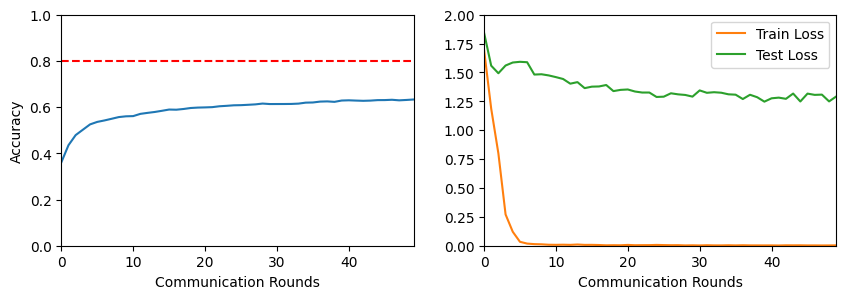

In [4]:
# cifar10.ipynb
from src.simulate import simulate
from src.helper import display_train_stats

dataset = 'CIFAR10'
img_path = f'./img/{dataset}'
stats_cifar_iid_cnn_10_10_5 = simulate('CIFAR10', num_clients=100, num_participants=10, batch_size=10, num_local_epochs=5, num_rounds=50, learning_rate=0.05, target_accuracy=0.80, iid=True, mlp=False)
display_train_stats(stats_cifar_iid_cnn_10_10_5, title=f"CIFAR10_IID_CNN_10_10_5", label="C=0.1, B=50, E=5", target_accuracy=0.80, save_path=img_path)